# 3d non-precessing example

# working on dag

In [1]:
import os

In [2]:
exe_names = dict(
    wf_gen = '/home/sebastian.khan/git/stk/scrinet/bin/dev/pipeline/gen_wf_data_3d_non_prec.py',
    wf_combine = '/home/sebastian.khan/git/stk/scrinet/bin/dev/pipeline/combine_wf_data.py',
    rb = '/home/sebastian.khan/git/stk/scrinet/bin/dev/pipeline/build_rb.py',
    gen_ts = '/home/sebastian.khan/git/stk/scrinet/bin/dev/pipeline/gen_ts_data.py',
    fit = '/home/sebastian.khan/git/stk/scrinet/bin/dev/pipeline/fit.py',
    eval_model = '/home/sebastian.khan/git/stk/scrinet/bin/dev/pipeline/evaluate_model.py'
)

In [8]:
from pycondor import Job, Dagman

root_output_dir = "/scratch/sebastian.khan/scrinet-3d-non-prec-test-output"

accounting_tag = "aluk.dev.o3.cbc.waveforms"
# accounting_tag = "ligo.dev.o3.cbc.pe.lalinference"

total_mass = 60

seed_npts = 3
seed_n_cores = 2
seed_memory = 500

train_npts_total = 10000
train_n_jobs = 100
train_n_cores = 4
train_memory = 1000
train_npts = int(train_npts_total/train_n_jobs)
print(f"train: number of points per job {train_npts}")

combine_train_memory = 1000

val_npts_total = 10000
val_n_jobs = 100
val_n_cores = 4
val_memory = 1000
val_npts = int(val_npts_total/val_n_jobs)
print(f"val: number of points per job {val_npts}")

combine_val_memory = 1000

test_npts_total = 10000
test_n_jobs = 100
test_n_cores = 4
test_memory = 1000
test_npts = int(test_npts_total/test_n_jobs)
print(f"test: number of points per job {test_npts}")

combine_test_memory = 1000


rb_amp_greedy_tol = 1e-3
rb_amp_memory = 5000

rb_phase_greedy_tol = 1e-3
rb_phase_memory = 5000

basis_method = 'eim'
# basis_method = 'rb'

ts_train_amp_memory = 5000
ts_val_amp_memory = 5000

ts_train_phase_memory = 5000
ts_val_phase_memory = 5000

fit_phase_memory = 3000
fit_phase_request_gpu = 1
fit_phase_batch_size = 100
fit_phase_epochs = 1000
fit_phase_input_units = 128
fit_phase_hidden_units = '128 128 128 128 128'

fit_amp_memory = 1000
fit_amp_request_gpu = 1
fit_amp_batch_size = 100
fit_amp_epochs = 1000
fit_amp_input_units = 128
fit_amp_hidden_units = '128 128 128 128 128'

eval_train_memory = 10000
eval_train_request_gpu = 0

eval_val_memory = 10000
eval_val_request_gpu = 0

eval_test_memory = 10000
eval_test_request_gpu = 0

# Define the error, output, log, and submit directories
error = os.path.abspath('3d-test-condor/error')
output = os.path.abspath('3d-test-condor/output')
log = os.path.abspath('3d-test-condor/log')
submit = os.path.abspath('3d-test-condor/submit')

dagman = Dagman(
    name='maindag',
    submit=submit
)

# seed data

subdag_seed = Dagman(name='subdag-seed-wf',
                    submit=submit,
                    dag=dagman)

seed_wf_job = Job(name='seed-wf',
                  executable=exe_names['wf_gen'],
                  arguments=f'--grid regular --npts {seed_npts} -v --n-cores {seed_n_cores} --output-dir {root_output_dir}/seed_wf_data --total-mass {total_mass}',
                  submit=submit,
                  error=error,
                  output=output,
                  log=log,
                  getenv=True,
                  universe="vanilla",
                  request_cpus=seed_n_cores,
                  request_memory=seed_memory,
                  extra_lines=[
                      f'accounting_group = {accounting_tag}',
                      'machine_count = 1'
                  ],
                  dag=subdag_seed
                 )


# training


subdag_training = Dagman(name='subdag-train-wf',
                    submit=submit,
                    dag=dagman)



combine_train_wf_job = Job(name=f"combine-train-wf",
                           executable=exe_names['wf_combine'],
                           arguments=f'-v --output-dir {root_output_dir}/train_wf_data --wf-dirs {root_output_dir}/train_wf_data_*',
                           submit=submit,
                           error=error,
                           output=output,
                           log=log,
                           getenv=True,
                           universe="vanilla",
                           request_cpus=1,
                           request_memory=combine_train_memory,
                           extra_lines=[
                               f'accounting_group = {accounting_tag}',
                               'machine_count = 1'
                           ],
                           dag=subdag_training
                          )



leading_zeros = len(str(train_n_jobs))

for n in range(train_n_jobs):
    
    # nice leading zeros that generalises to any number of n_train_job
    zstr = str(n).zfill(leading_zeros)
    
    train_wf_job = Job(name=f"train-wf-{zstr}",
                      executable=exe_names['wf_gen'],
                      arguments=f'--grid random --npts {train_npts} -v --n-cores {train_n_cores} --output-dir {root_output_dir}/train_wf_data_{zstr} --total-mass {total_mass}',
                      submit=submit,
                      error=error,
                      output=output,
                      log=log,
                      getenv=True,
                      universe="vanilla",
                      request_cpus=train_n_cores,
                      request_memory=train_memory,
                      extra_lines=[
                          f'accounting_group = {accounting_tag}',
                          'machine_count = 1'
                      ],
                      dag=subdag_training
                     )

    combine_train_wf_job.add_parent(train_wf_job)
    

# validation

subdag_validation = Dagman(name='subdag-validation-wf',
                    submit=submit,
                    dag=dagman)


combine_validation_wf_job = Job(name=f"combine-validation-wf",
                           executable=exe_names['wf_combine'],
                           arguments=f'-v --output-dir {root_output_dir}/validation_wf_data --wf-dirs {root_output_dir}/validation_wf_data_*',
                           submit=submit,
                           error=error,
                           output=output,
                           log=log,
                           getenv=True,
                           universe="vanilla",
                           request_cpus=1,
                           request_memory=combine_val_memory,
                           extra_lines=[
                               f'accounting_group = {accounting_tag}',
                               'machine_count = 1'
                           ],
                           dag=subdag_validation
                          )



leading_zeros = len(str(val_n_jobs))

for n in range(val_n_jobs):
    
    zstr = str(n).zfill(leading_zeros)
    
    validation_wf_job = Job(name=f"validation-wf-{zstr}",
                      executable=exe_names['wf_gen'],
                      arguments=f'--grid random --npts {val_npts} -v --n-cores {val_n_cores} --output-dir {root_output_dir}/validation_wf_data_{zstr} --total-mass {total_mass}',
                      submit=submit,
                      error=error,
                      output=output,
                      log=log,
                      getenv=True,
                      universe="vanilla",
                      request_cpus=val_n_cores,
                      request_memory=val_memory,
                      extra_lines=[
                          f'accounting_group = {accounting_tag}',
                          'machine_count = 1'
                      ],
                      dag=subdag_validation
                     )

    combine_validation_wf_job.add_parent(validation_wf_job)
    
    
    
    
# test

subdag_test = Dagman(name='subdag-test-wf',
                    submit=submit,
                    dag=dagman)


combine_test_wf_job = Job(name=f"combine-test-wf",
                           executable=exe_names['wf_combine'],
                           arguments=f'-v --output-dir {root_output_dir}/test_wf_data --wf-dirs {root_output_dir}/test_wf_data_*',
                           submit=submit,
                           error=error,
                           output=output,
                           log=log,
                           getenv=True,
                           universe="vanilla",
                           request_cpus=1,
                           request_memory=combine_test_memory,
                           extra_lines=[
                               f'accounting_group = {accounting_tag}',
                               'machine_count = 1'
                           ],
                           dag=subdag_test
                          )



leading_zeros = len(str(test_n_jobs))

for n in range(test_n_jobs):
    
    zstr = str(n).zfill(leading_zeros)
    
    test_wf_job = Job(name=f"test-wf-{zstr}",
                      executable=exe_names['wf_gen'],
                      arguments=f'--grid random --npts {test_npts} -v --n-cores {test_n_cores} --output-dir {root_output_dir}/test_wf_data_{zstr} --total-mass {total_mass}',
                      submit=submit,
                      error=error,
                      output=output,
                      log=log,
                      getenv=True,
                      universe="vanilla",
                      request_cpus=test_n_cores,
                      request_memory=test_memory,
                      extra_lines=[
                          f'accounting_group = {accounting_tag}',
                          'machine_count = 1'
                      ],
                      dag=subdag_test
                     )

    combine_test_wf_job.add_parent(test_wf_job)
    
    
    
##

subdag_rb_amp = Dagman(name='subdag-rb-amp',
                    submit=submit,
                    dag=dagman)



rb_amp_job = Job(name=f"rb-amp",
                           executable=exe_names['rb'],
                           arguments=f'--data-to-model amp -v --greedy-tol {rb_amp_greedy_tol} --output-dir {root_output_dir}/rb --seed-dir {root_output_dir}/seed_wf_data --train-dir {root_output_dir}/train_wf_data',
                           submit=submit,
                           error=error,
                           output=output,
                           log=log,
                           getenv=True,
                           universe="vanilla",
                           request_cpus=1,
                           request_memory=rb_amp_memory,
                           extra_lines=[
                               f'accounting_group = {accounting_tag}',
                               'machine_count = 1'
                           ],
                           dag=subdag_rb_amp
                          )

subdag_rb_amp.add_parents([subdag_seed, subdag_training])


##

subdag_rb_phase = Dagman(name='subdag-rb-phase',
                    submit=submit,
                    dag=dagman)



rb_phase_job = Job(name=f"rb-phase",
                           executable=exe_names['rb'],
                           arguments=f'--data-to-model phase -v --greedy-tol {rb_phase_greedy_tol} --output-dir {root_output_dir}/rb --seed-dir {root_output_dir}/seed_wf_data --train-dir {root_output_dir}/train_wf_data',
                           submit=submit,
                           error=error,
                           output=output,
                           log=log,
                           getenv=True,
                           universe="vanilla",
                           request_cpus=1,
                           request_memory=rb_phase_memory,
                           extra_lines=[
                               f'accounting_group = {accounting_tag}',
                               'machine_count = 1'
                           ],
                           dag=subdag_rb_phase
                          )

subdag_rb_phase.add_parents([subdag_seed, subdag_training])

##

subdag_ts_train_amp = Dagman(name='subdag-ts-train-amp',
                    submit=submit,
                    dag=dagman)



ts_train_amp_job = Job(name=f"ts-train-amp",
                           executable=exe_names['gen_ts'],
                           arguments=f'--train-or-val train --data-to-model amp -v --basis-method {basis_method} --wf-dir {root_output_dir}/train_wf_data --basis-dir {root_output_dir}/rb --output-dir {root_output_dir}/ts',
                           submit=submit,
                           error=error,
                           output=output,
                           log=log,
                           getenv=True,
                           universe="vanilla",
                           request_cpus=1,
                           request_memory=ts_train_amp_memory,
                           extra_lines=[
                               f'accounting_group = {accounting_tag}',
                               'machine_count = 1'
                           ],
                           dag=subdag_ts_train_amp
                          )

subdag_ts_train_amp.add_parent(subdag_rb_amp)


subdag_ts_val_amp = Dagman(name='subdag-ts-val-amp',
                    submit=submit,
                    dag=dagman)


ts_val_amp_job = Job(name=f"ts-val-amp",
                           executable=exe_names['gen_ts'],
                           arguments=f'--train-or-val val --data-to-model amp -v --basis-method {basis_method} --wf-dir {root_output_dir}/validation_wf_data --basis-dir {root_output_dir}/rb --output-dir {root_output_dir}/ts',
                           submit=submit,
                           error=error,
                           output=output,
                           log=log,
                           getenv=True,
                           universe="vanilla",
                           request_cpus=1,
                           request_memory=ts_val_amp_memory,
                           extra_lines=[
                               f'accounting_group = {accounting_tag}',
                               'machine_count = 1'
                           ],
                           dag=subdag_ts_val_amp
                          )

subdag_ts_val_amp.add_parents([subdag_rb_amp, subdag_validation])

##


subdag_ts_train_phase = Dagman(name='subdag-ts-train-phase',
                    submit=submit,
                    dag=dagman)



ts_train_phase_job = Job(name=f"ts-train-phase",
                           executable=exe_names['gen_ts'],
                           arguments=f'--train-or-val train --data-to-model phase -v --basis-method {basis_method} --wf-dir {root_output_dir}/train_wf_data --basis-dir {root_output_dir}/rb --output-dir {root_output_dir}/ts',
                           submit=submit,
                           error=error,
                           output=output,
                           log=log,
                           getenv=True,
                           universe="vanilla",
                           request_cpus=1,
                           request_memory=ts_train_phase_memory,
                           extra_lines=[
                               f'accounting_group = {accounting_tag}',
                               'machine_count = 1'
                           ],
                           dag=subdag_ts_train_phase
                          )


subdag_ts_train_phase.add_parent(subdag_rb_phase)

subdag_ts_val_phase = Dagman(name='subdag-ts-val-phase',
                    submit=submit,
                    dag=dagman)



ts_val_phase_job = Job(name=f"ts-val-phase",
                           executable=exe_names['gen_ts'],
                           arguments=f'--train-or-val val --data-to-model phase -v --basis-method {basis_method} --wf-dir {root_output_dir}/validation_wf_data --basis-dir {root_output_dir}/rb --output-dir {root_output_dir}/ts',
                           submit=submit,
                           error=error,
                           output=output,
                           log=log,
                           getenv=True,
                           universe="vanilla",
                           request_cpus=1,
                           request_memory=ts_val_phase_memory,
                           extra_lines=[
                               f'accounting_group = {accounting_tag}',
                               'machine_count = 1'
                           ],
                           dag=subdag_ts_val_phase
                          )

subdag_ts_val_phase.add_parents([subdag_rb_phase, subdag_validation])



## finally onto the fitting

subdag_fit_phase = Dagman(name='subdag-fit-phase',
                    submit=submit,
                    dag=dagman)




fit_phase_job = Job(name=f"fit-phase",
                           executable=exe_names['fit'],
                           arguments=f'--data-to-model phase -v --scaleX --scaleY --ts-dir {root_output_dir}/ts --output-dir {root_output_dir}/ts --epochs {fit_phase_epochs} --batch-size {fit_phase_batch_size} --input-units {fit_phase_input_units} --hidden-units {fit_phase_hidden_units}',
                           submit=submit,
                           error=error,
                           output=output,
                           log=log,
                           getenv=True,
                           universe="vanilla",
                           request_cpus=1,
                           request_memory=fit_phase_memory,
                           extra_lines=[
                               f'accounting_group = {accounting_tag}',
                               'machine_count = 1',
                               f'request_gpus = {fit_phase_request_gpu}'
                           ],
                           dag=subdag_fit_phase
                          )

subdag_fit_phase.add_parents([subdag_ts_train_phase, subdag_ts_val_phase])


##

subdag_fit_amp = Dagman(name='subdag-fit-amp',
                    submit=submit,
                    dag=dagman)


fit_amp_job = Job(name=f"fit-amp",
                           executable=exe_names['fit'],
                           arguments=f'--data-to-model amp -v --scaleX --scaleY --ts-dir {root_output_dir}/ts --output-dir {root_output_dir}/ts --epochs {fit_amp_epochs} --batch-size {fit_amp_batch_size} --input-units {fit_amp_input_units} --hidden-units {fit_amp_hidden_units}',
                           submit=submit,
                           error=error,
                           output=output,
                           log=log,
                           getenv=True,
                           universe="vanilla",
                           request_cpus=1,
                           request_memory=fit_amp_memory,
                           extra_lines=[
                               f'accounting_group = {accounting_tag}',
                               'machine_count = 1',
                               f'request_gpus = {fit_amp_request_gpu}'
                           ],
                           dag=subdag_fit_amp
                          )

subdag_fit_amp.add_parents([subdag_ts_train_amp, subdag_ts_val_amp])


## finally evaluation

## training set

subdag_eval_train = Dagman(name='subdag-eval-train',
                    submit=submit,
                    dag=dagman)


eval_train_job = Job(name=f"eval-train",
                           executable=exe_names['eval_model'],
                           arguments=f'-v --wf-dir {root_output_dir}/train_wf_data --output-dir {root_output_dir}/evaluate --amp-basis {root_output_dir}/rb/amp/amp_eim_basis.npy  --amp-model-dir {root_output_dir}/ts/amp/fits --phase-basis {root_output_dir}/rb/phase/phase_eim_basis.npy  --phase-model-dir {root_output_dir}/ts/phase/fits',
                           submit=submit,
                           error=error,
                           output=output,
                           log=log,
                           getenv=True,
                           universe="vanilla",
                           request_cpus=1,
                           request_memory=eval_train_memory,
                           extra_lines=[
                               f'accounting_group = {accounting_tag}',
                               'machine_count = 1',
                               f'request_gpus = {eval_train_request_gpu}'
                           ],
                           dag=subdag_eval_train
                          )

subdag_eval_train.add_parents([subdag_fit_amp, subdag_fit_phase])

## validation set

subdag_eval_val = Dagman(name='subdag-eval-val',
                    submit=submit,
                    dag=dagman)



eval_val_job = Job(name=f"eval-val",
                           executable=exe_names['eval_model'],
                           arguments=f'-v --wf-dir {root_output_dir}/validation_wf_data --output-dir {root_output_dir}/evaluate --amp-basis {root_output_dir}/rb/amp/amp_eim_basis.npy  --amp-model-dir {root_output_dir}/ts/amp/fits --phase-basis {root_output_dir}/rb/phase/phase_eim_basis.npy  --phase-model-dir {root_output_dir}/ts/phase/fits',
                           submit=submit,
                           error=error,
                           output=output,
                           log=log,
                           getenv=True,
                           universe="vanilla",
                           request_cpus=1,
                           request_memory=eval_train_memory,
                           extra_lines=[
                               f'accounting_group = {accounting_tag}',
                               'machine_count = 1',
                               f'request_gpus = {eval_val_request_gpu}'
                           ],
                           dag=subdag_eval_val
                          )

subdag_eval_val.add_parents([subdag_fit_amp, subdag_fit_phase])

## test set

subdag_eval_test = Dagman(name='subdag-eval-test',
                    submit=submit,
                    dag=dagman)



eval_test_job = Job(name=f"eval-test",
                           executable=exe_names['eval_model'],
                           arguments=f'-v --wf-dir {root_output_dir}/test_wf_data --output-dir {root_output_dir}/evaluate --amp-basis {root_output_dir}/rb/amp/amp_eim_basis.npy  --amp-model-dir {root_output_dir}/ts/amp/fits --phase-basis {root_output_dir}/rb/phase/phase_eim_basis.npy  --phase-model-dir {root_output_dir}/ts/phase/fits',
                           submit=submit,
                           error=error,
                           output=output,
                           log=log,
                           getenv=True,
                           universe="vanilla",
                           request_cpus=1,
                           request_memory=eval_train_memory,
                           extra_lines=[
                               f'accounting_group = {accounting_tag}',
                               'machine_count = 1',
                               f'request_gpus = {eval_test_request_gpu}'
                           ],
                           dag=subdag_eval_test
                          )

subdag_eval_test.add_parents([subdag_test, subdag_fit_amp, subdag_fit_phase]);

train: number of points per job 100
val: number of points per job 100
test: number of points per job 100


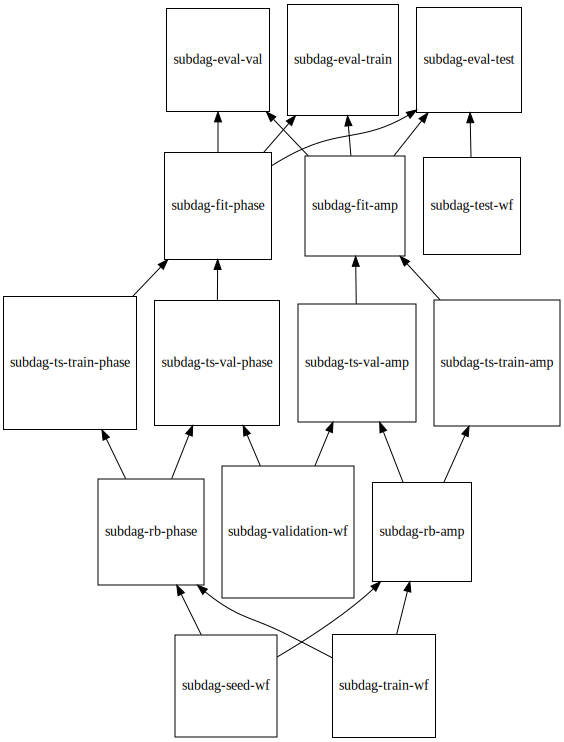

In [9]:
dagman.visualize('workflow.png')

In [11]:
subdag_ts_train_amp.visualize('workflow.png')

In [12]:
subdag_rb_amp.visualize('workflow.png')

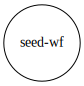

In [13]:
subdag_seed.visualize('workflow.png')

In [14]:
subdag_validation.visualize('workflow.png')

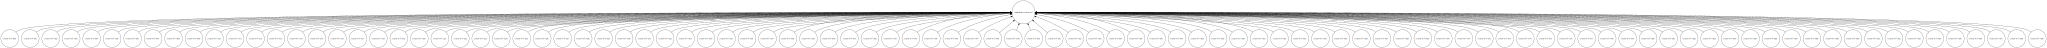

In [15]:
subdag_training.visualize('workflow.png')

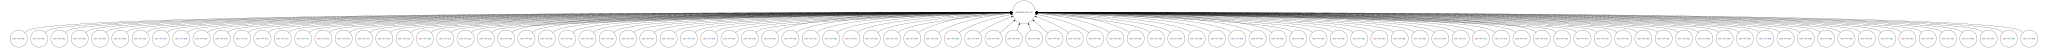

In [16]:
subdag_test.visualize('workflow.png')

In [ ]:
dagman.build()

print("\n\n\n")
print(f"condor_submit_dag {dagman.submit_file}")